In [18]:
# imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import colors
from matplotlib import animation
from matplotlib import pyplot as plt
import pylab

from scipy.cluster.hierarchy import cophenet, linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

%run 'parse.ipynb'
#%matplotlib inline
#%matplotlib notebook

In [5]:
# load data
s = [parse(data_type='training', subj=i) for i in range(1,21)] # train

In [6]:
def reordered_corrplot(C, metric='correlation'):
    Z = linkage(C, 'single', metric)
    D = dendrogram(Z, orientation='right')
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
    
    index = D['leaves']
    
    C = C[index,:]
    C = C[:,index]
    
    im = axmatrix.matshow(C, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    pylab.colorbar(im, cax=axcolor)

    # Display and save figure.
    fig.show()
    return index
    
# Average ...

<IPython.core.display.Javascript object>


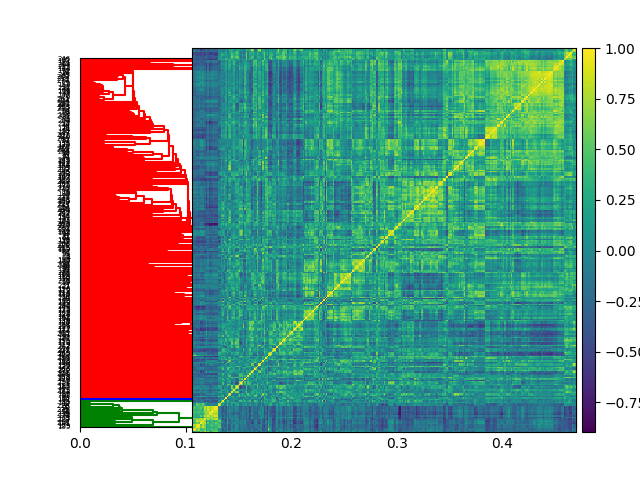

<IPython.core.display.Javascript object>


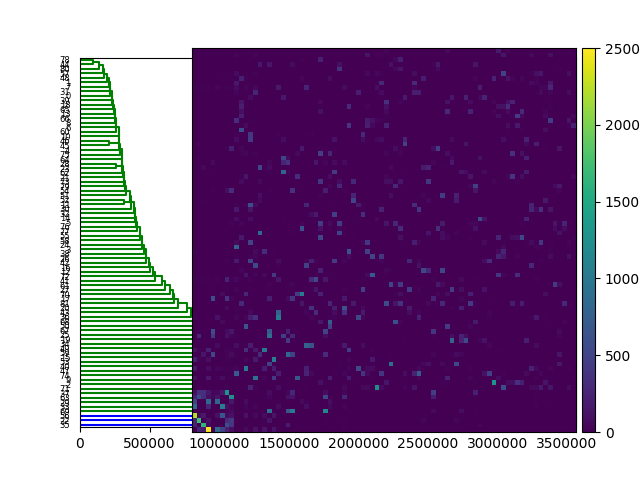

<IPython.core.display.Javascript object>


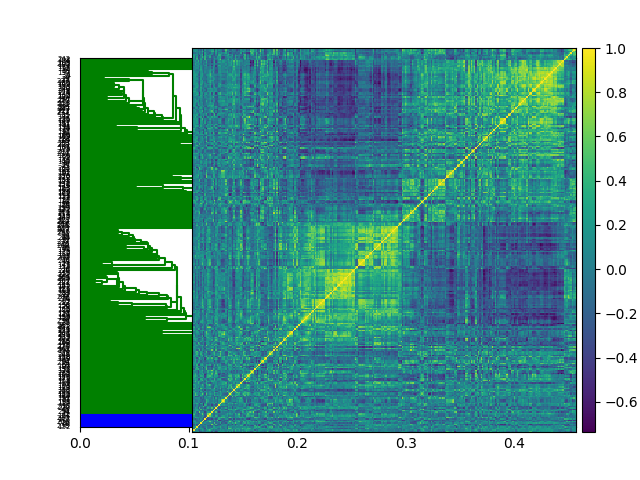

<IPython.core.display.Javascript object>


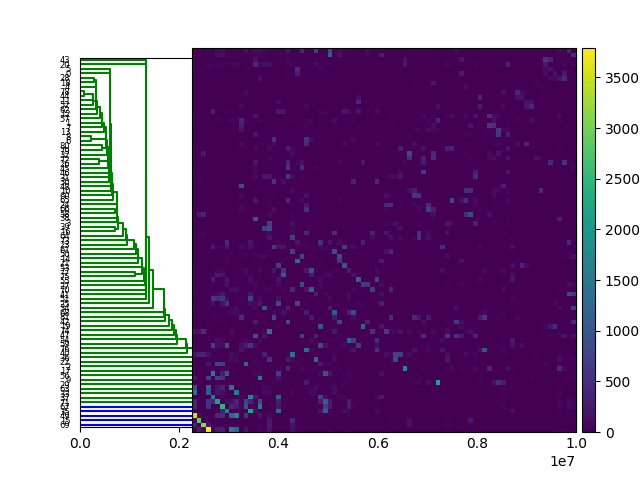

In [6]:
fig = plt.figure()
#print s[0]['Pre_RS'].shape
C = s[0]['Pre_RS'].as_matrix()[1:,1:]
C_idx = reordered_corrplot(C)
                   
fig=plt.figure()
C2 = s[1]['Pre_FS'].as_matrix()
C2_idx = reordered_corrplot(C2, 'sqeuclidean')

fig = plt.figure()
C = s[2]['Pre_RS'].as_matrix()[1:, 1:]
C_idx = reordered_corrplot(C)

fig=plt.figure()
C2 = s[3]['Pre_FS'].as_matrix()
C2_idx = reordered_corrplot(C2, 'sqeuclidean')

In [7]:
C = np.nansum([s[i]['Pre_RS'].as_matrix()[1:,1:] for i in range(20)], axis=0) / 20.0

<IPython.core.display.Javascript object>


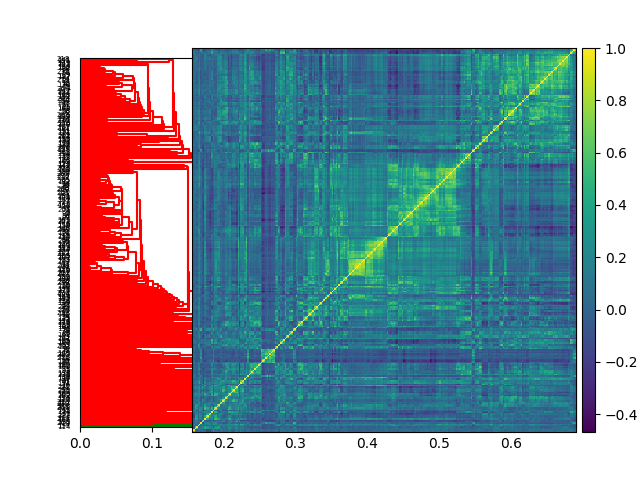

[114,
 157,
 29,
 260,
 175,
 166,
 219,
 117,
 232,
 177,
 67,
 174,
 57,
 143,
 201,
 238,
 103,
 230,
 112,
 216,
 113,
 150,
 24,
 262,
 100,
 163,
 60,
 251,
 259,
 51,
 272,
 10,
 154,
 72,
 41,
 97,
 127,
 148,
 38,
 235,
 158,
 133,
 93,
 5,
 71,
 186,
 192,
 220,
 66,
 137,
 65,
 48,
 271,
 173,
 210,
 125,
 140,
 75,
 12,
 30,
 193,
 200,
 53,
 160,
 109,
 85,
 161,
 202,
 73,
 162,
 89,
 8,
 39,
 78,
 195,
 183,
 63,
 136,
 179,
 258,
 124,
 115,
 19,
 34,
 40,
 145,
 231,
 59,
 223,
 54,
 229,
 44,
 87,
 139,
 58,
 228,
 131,
 189,
 164,
 126,
 244,
 276,
 275,
 171,
 196,
 96,
 110,
 79,
 239,
 242,
 86,
 108,
 249,
 152,
 83,
 207,
 222,
 116,
 155,
 226,
 52,
 269,
 11,
 13,
 167,
 274,
 35,
 107,
 204,
 105,
 213,
 22,
 221,
 234,
 184,
 119,
 101,
 246,
 120,
 95,
 256,
 84,
 16,
 194,
 215,
 26,
 172,
 81,
 268,
 146,
 28,
 156,
 159,
 6,
 241,
 253,
 165,
 99,
 7,
 56,
 92,
 0,
 4,
 205,
 33,
 49,
 153,
 138,
 277,
 27,
 3,
 147,
 104,
 252,
 254,
 31,
 261,
 70,
 26

In [8]:
fig = plt.figure()
reordered_corrplot(C)

In [9]:
locs = s[0]['XYZ'].loc[range(1,279),('X','Y','Z')].as_matrix()
#locs.shape

<IPython.core.display.Javascript object>


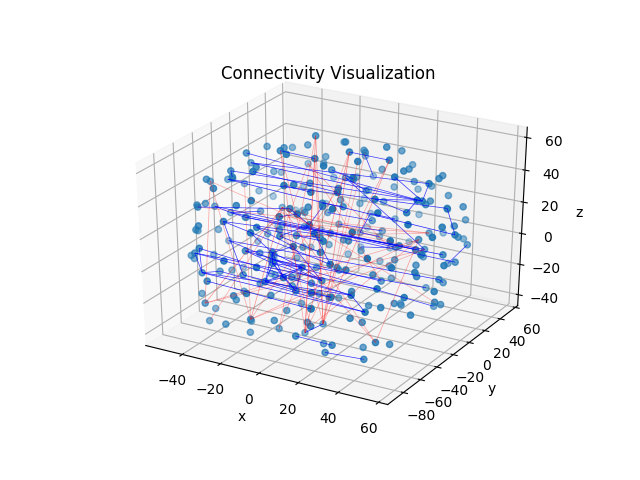

In [28]:
def conn_plot(ax, C, locs):
    ax.scatter(locs[:,0], locs[:,1], locs[:,2])
    x,y,z = locs[:,0], locs[:,1], locs[:,2]
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    ax.set_zlim(np.min(z), np.max(z))

    blue = (0.0,0.0,1.0)
    red = (1.0,0.0,0.0)

    p1s = []
    p2s = []
    cols = []
    # connections
    n = len(C)
    for i in range(n):
        for j in range(i,n):
            if C[i,j]>0.75 or C[i,j] < -0.3: #draw-thresh
                p1s.append(locs[i])
                p2s.append(locs[j])
                col = blue if C[i,j]>0 else red
                col = col + tuple((abs(C[i,j]),))
                cols.append(col)

    ls = np.hstack([p1s, p2s]).copy()
    ls = ls.reshape((-1,2,3))

    lc = Line3DCollection(ls, linewidths=0.5, colors=cols)
    ax.add_collection(lc)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Connectivity Visualization')
    
    
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')
conn_plot(ax, C, locs)
fig.show()

# def init():
#     #ax.scatter(xx, yy, zz, marker='o', s=20, c="goldenrod", alpha=0.6)
#     return fig,

# def animate(i):
#     ax.view_init(azim=i)
#     return fig,

# # Animate
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=range(0,360,2), interval=100, blit=True)
# # Save
# anim.save('connectivity.gif', fps=20)

<IPython.core.display.Javascript object>


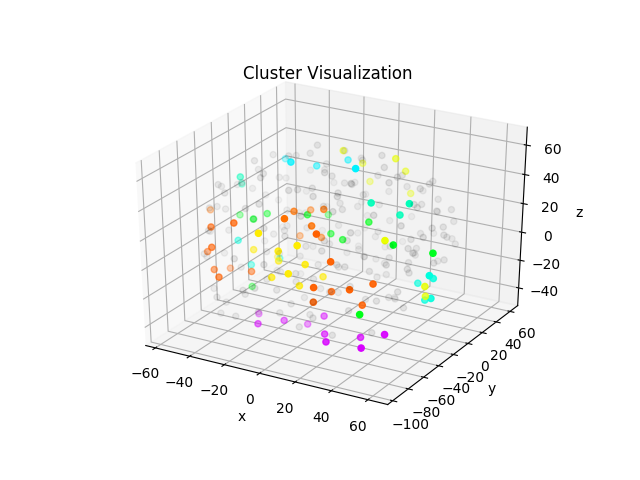

In [25]:
def cluster(C, n_c, thresh=1.05):
    Z = linkage(C, 'single', 'correlation')
    m = fcluster(Z, thresh)
    cnt = np.bincount(m)
    cls = np.argsort(cnt)[::-1] # big clusters first
    n_c = 10
    idx = [np.where(m == cls[i])[0] for i in range(n_c)]
    return idx
   
#%matplotlib notebook
cls = cluster(C, 10)

ext = set(range(278))
for c in cls:
    ext = ext - set(c)
ext = np.array(list(ext))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = len(cls)
cols = np.concatenate([np.random.random(size=(n,1)), np.ones((n,2))], axis=1)
cols = colors.hsv_to_rgb(cols)

for c, col in zip(cls, cols):
    ax.scatter(locs[c,0], locs[c,1], locs[c,2], c=col)

ax.scatter(locs[ext,0], locs[ext,1], locs[ext,2], c=(0.0,0.0,0.0,0.1))

# ax.view_init(azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Cluster Visualization')

def init():
    #ax.scatter(xx, yy, zz, marker='o', s=20, c="goldenrod", alpha=0.6)
    return fig,

def animate(i):
    ax.view_init(azim=i)
    return fig,

# Animate
#anim = animation.FuncAnimation(fig, animate, init_func=init,
#                               frames=range(0,360,2), interval=100, blit=True)

# Save
#anim.save('clusters.gif', fps=20)

#print C

#conn_plot(ax, C[np.ix_(c,c)], locs[c])
#conn_plot(ax, C[np.ix_(cls[1],cls[1])], locs[cls[1]])

#fig.show()
#plt.show() 

# identify clusters
# multiply each

<IPython.core.display.Javascript object>


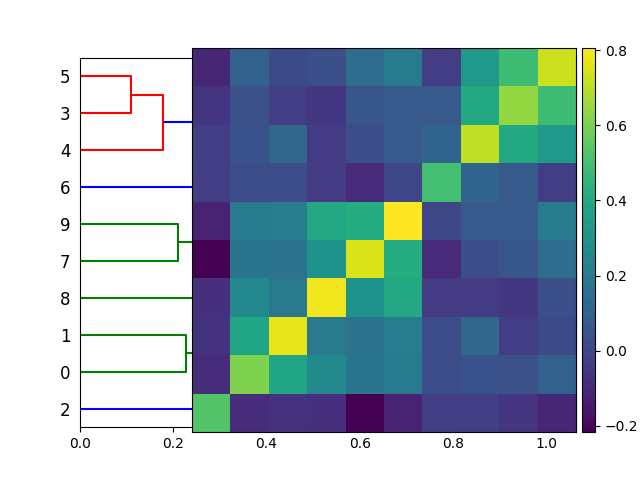

In [137]:
def cluster_corr(C, cls):
    n = len(cls)
    new_C = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            new_C[i,j] = new_C[j,i] = np.mean(C[np.ix_(cls[i], cls[j])])
            # TODO : incorporate fuzziness?
    return new_C
new_C = cluster_corr(C, cls)

fig = plt.figure()
reordered_corrplot(new_C)
fig.show()


In [141]:
class ClusterReducer(object):
    def __init__(self, data, thresh=1.05, n_cluster=10):
        """
        data : given as list of NxN matrices that encode connectivity
            between regions.
        """
        self._data = data
        self._n_c = n_cluster
        self._cls = self.__build(thresh)
        
    def __build(self, thresh):
        C = np.nansum(self._data, axis=0) / len(self._data)
        Z = linkage(C, 'single', 'correlation') # TODO : variable metric
        m = fcluster(Z, thresh)
        cnt = np.bincount(m)
        cls = np.argsort(cnt)[::-1] # big clusters first
        n_c = 10
        idx = [np.where(m == cls[i])[0] for i in range(self._n_c)]
        return idx
    
    def __call__(self, C):
        """
        Takes connectivity data, reduces it to new connectivity built from clusters
        """
        n = self._n_c
        new_C = np.zeros((n,n))
        for i in range(n):
            for j in range(i, n):
                new_C[i,j] = new_C[j,i] = np.mean(C[np.ix_(self._cls[i], self._cls[j])])
            # TODO : incorporate fuzziness?
        return new_C

In [142]:
data = [s[i]['Pre_RS'].as_matrix()[1:,1:] for i in range(20)]
rdc = ClusterReducer(data)
C = rdc(s[i]['Post_RS'].as_matrix())

<IPython.core.display.Javascript object>


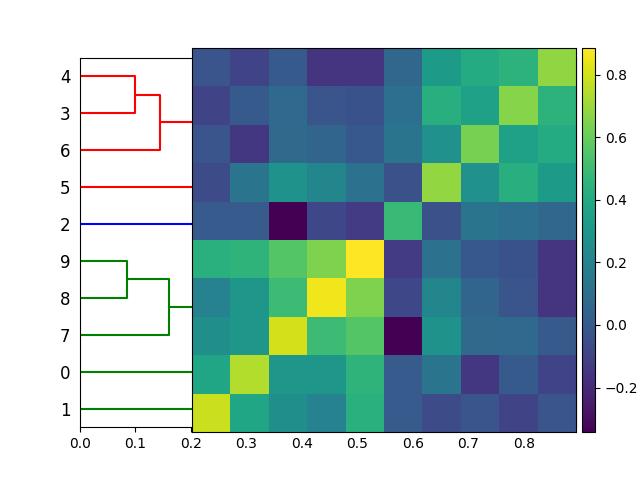

In [145]:
fig = plt.figure()
reordered_corrplot(C)
fig.show()